In [1]:
!pip uninstall -y torch torchtext torchvision torchaudio
!pip list | grep torch

!pip install torch==2.2.2 torchtext==0.17.2 numpy==1.26.4

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
pytorch-ignite                     0.5.1
pytorch-lightning                  2.5.0.post0
torchinfo                          1.8.0
torchmetrics                       1.6.1
torchsummary                       1.5.1
torchtune                          0.5.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from collections import Counter
import re
from torchinfo import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings 
warnings.filterwarnings("ignore")

In [3]:
# Step 1: Data Preparation
class ArabicSentimentDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        numericalized_text = [self.vocab[word] for word in text]
        return torch.tensor(numericalized_text, dtype=torch.long), torch.tensor(label, dtype=torch.long)

In [4]:
# Step 2: Preprocessing
def preprocess_arabic_text(text):
    # Remove diacritics and special characters
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'[ًٌٍَُِّْـ]', '', text)  # Remove Arabic diacritics
    text = re.sub(r'\b[A-Za-z]+\b', '', text)  # Remove English words
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text.split()

In [5]:
# Step 3: Build vocabulary
def yield_tokens(texts):
    for text in texts:
        yield text

In [6]:
# Load data
df = pd.read_csv('/kaggle/input/330k-arabic-sentiment-reviews/arabic_sentiment_reviews.csv')
df.head()

,label,content
0,1,النعال المريحة: أرتدي هذه النعال كثيرًا!فهي دا...
1,1,منتج جميل ، خدمة سيئة: لقد اشتريت زوجًا من الن...
2,1,جيد للأشياء الصغيرة: هذا يعمل بشكل جيد لالتقاط...
3,0,واهية للغاية: flimsyif للغاية ، فأنت تشتريه ، ...
4,1,Pop for Girls and Girly Boys ، والأشخاص الذين ...


In [7]:
df.label.value_counts()

label
1    166853
0    163147
Name: count, dtype: int64

In [8]:
texts = df['content'].apply(preprocess_arabic_text).tolist()
labels = df['label'].values

In [9]:
# Build vocabulary
vocab = build_vocab_from_iterator(yield_tokens(texts), specials=['<pad>', '<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [10]:
# Get vocabulary details
vocab_size = len(vocab)
word_freq = Counter(word for text in texts for word in text)  # Count word frequencies
most_common_words = word_freq.most_common(20)  # Top 20 most common words
# Print results
print(f"📌 Vocabulary Size: {vocab_size}")
print("🔝 Top 20 Most Common Words:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")

📌 Vocabulary Size: 978029
🔝 Top 20 Most Common Words:
من: 639005
في: 510952
على: 364256
هذا: 364133
أن: 323085
لا: 191839
إلى: 190703
كان: 121194
مع: 120446
هو: 119015
ما: 118578
الكتاب: 117525
التي: 109022
هذه: 101985
ذلك: 98159
لم: 93631
عن: 85602
كنت: 81392
أو: 77854
الذي: 73208


In [11]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5)
print(f"Train Shape: {len(X_train)}")
print(f"Test Shape: {len(X_test)}")
print(f"Validation Shape: {len(X_val)}")

Train Shape: 264000
Test Shape: 33000
Validation Shape: 33000


In [12]:
# Create datasets
train_dataset = ArabicSentimentDataset(X_train, y_train, vocab)
test_dataset = ArabicSentimentDataset(X_test, y_test, vocab)
val_dataset = ArabicSentimentDataset(X_val, y_val, vocab)

In [13]:
# Create dataloaders with padding
# Step 5: Define collate function
def collate_fn(batch):
    texts, labels = zip(*batch)
    padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=vocab['<pad>'])
    return padded_texts, torch.tensor(labels, dtype=torch.long)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)

In [14]:
# Step 4: Model Definition
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim,hidden_dim, output_dim=2, n_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True, bidirectional=True)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, _) = self.lstm(embedded)
        hidden = self.batch_norm(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        hidden = self.dropout(hidden)
        return self.fc(hidden)

In [15]:
# Step 5: Callbacks
class Callback:
    def __init__(self, patience=3, min_delta=0.001, lr_scheduler=None, factor=0.1, lr_patience=2):
        """
        Args:
            patience (int): Number of epochs to wait before early stopping if no improvement.
            min_delta (float): Minimum change in validation loss to qualify as an improvement.
            lr_scheduler (torch.optim.lr_scheduler.ReduceLROnPlateau): Learning rate scheduler.
            factor (float): Factor by which to reduce learning rate.
            lr_patience (int): Number of epochs to wait before reducing learning rate.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
        # Learning Rate Scheduler
        self.lr_scheduler = lr_scheduler
        self.lr_patience = lr_patience
        self.lr_counter = 0  # Tracks epochs without improvement for LR scheduling
        self.factor = factor

    def on_epoch_end(self, val_loss, model, optimizer):
        """
        Called at the end of each epoch.
        
        Args:
            val_loss (float): Validation loss.
            model (torch.nn.Module): The model being trained.
            optimizer (torch.optim.Optimizer): The optimizer being used.
        """
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.lr_counter = 0  # Reset LR counter
            torch.save(model,'best_model.pth') # Save best model
            print(f"Best model saved with validation loss: {val_loss:.4f}")
        else:
            self.counter += 1
            self.lr_counter += 1
            # Reduce learning rate if no improvement for `lr_patience` epochs
            if self.lr_scheduler and self.lr_counter >= self.lr_patience:
                self.lr_scheduler.step(val_loss)
                self.lr_counter = 0  # Reset LR counter
            # Trigger early stopping if no improvement for `patience` epochs
            if self.counter >= self.patience:
                self.early_stop = True

In [16]:
# Step 6: Training Function
def train_epoch(model, optimizer, loss_fn, data_loader, device):
    """
    Trains the model for one epoch and calculates training loss & accuracy.

    Args:
        model (torch.nn.Module): The model being trained.
        optimizer (torch.optim.Optimizer): Optimizer for updating weights.
        loss_fn (torch.nn.Module): Loss function.
        data_loader (DataLoader): DataLoader for training data.
        device (str): Device to use ('cuda' or 'cpu').

    Returns:
        tuple: (Average Training Loss, Training Accuracy)
    """
    # Initialize loss and accuracy variables
    training_loss = 0.0
    correct = 0
    total = 0
    # Set the model to training mode
    model.train()
    # Loop through batches
    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):
        # Move inputs & targets to the same device
        inputs, targets = inputs.to(device), targets.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Compute loss
        loss = loss_fn(outputs, targets)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        # Update cumulative loss
        training_loss += loss.item() * inputs.size(0)
        # Compute correct predictions
        predictions = torch.argmax(outputs, dim=1)
        correct += (predictions == targets).sum().item()
        total += targets.size(0)
    # Compute average loss & accuracy
    avg_loss = training_loss / len(data_loader.dataset)
    train_accuracy = correct / total
    return avg_loss, train_accuracy

In [17]:
# Step 7: Prediction Function
def predict(model, data_loader,device):
    # This tensor will store all of the predictions.
    all_probs = torch.tensor([],device=device)
    # We set the model to evaluation mode. This mode is the opposite of
    # train mode we set in the train_epoch function.
    model.eval()
    # Since we're not training, we don't need any gradient calculations.
    # This tells PyTorch not to calculate any gradients, which speeds up
    # some calculations.
    with torch.no_grad():
        # Again, we iterate over the batches in the data loader and feed
        # them into the model for the forward pass.
        for inputs, targets in tqdm(data_loader, desc="Predicting", leave=False):
            # add inputs to same device
            inputs = inputs.to(device)
            output = model(inputs)
            # The model produces the logits.  This softmax function turns the
            # logits into probabilities.  These probabilities are concatenated
            # into the `all_probs` tensor.
            probs = F.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)
    return all_probs

In [18]:
# Step 8: Score Function
def score(model, data_loader, loss_fn,device):
    # Initialize the total loss (cross entropy) and the number of correct
    # predictions. We'll increment these values as we loop through the
    # data.
    total_loss = 0
    total_correct = 0
    # We set the model to evaluation mode. This mode is the opposite of
    # train mode we set in the train_epoch function.
    #model.eval()
    # Since we're not training, we don't need any gradient calculations.
    # This tells PyTorch not to calculate any gradients, which speeds up
    # some calculations.
    with torch.no_grad():
        # We iterate over the batches in the data loader and feed
        # them into the model for the forward pass.
        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            # add inputs and targets to same device
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            # Calculating the loss function for this batch
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)
            # Calculating the correct predictions for this batch
            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()
    return total_loss / len(data_loader.dataset), total_correct / len(
        data_loader.dataset
    )

In [19]:
# Step 6: Combine all Training Function
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs=10, device="cuda"):
    """
    Trains the model and evaluates on validation set after each epoch.
    Returns:
        pd.DataFrame with training loss, validation loss, training accuracy, validation accuracy, and LR.
    """
    # Initialize early stopping & learning rate scheduler
    callback = Callback(patience=5, min_delta=0.001, lr_scheduler=scheduler, lr_patience=2)
    # Store results
    results = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Train Acc', 'Val Loss', 'Val Acc', 'LR'])
    for epoch in range(1, epochs + 1):
        # Train for one epoch
        train_loss, train_acc = train_epoch(model, optimizer, criterion, train_loader, device)
        # Evaluate on validation set
        val_loss, val_accuracy = score(model, val_loader, criterion, device)
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        # Store results
        results.loc[epoch] = [epoch, train_loss, train_acc, val_loss, val_accuracy, current_lr]
        # Print epoch summary
        print(f"Epoch {epoch}/{epochs}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4%}, "
              f"Val Loss = {val_loss:.4f}, Val Acc = {val_accuracy:.4%}, LR = {current_lr:.6f}")
        # Apply early stopping and learning rate scheduler
        callback.on_epoch_end(val_loss, model, optimizer)
        if callback.early_stop:
            print(f"Early stopping triggered at epoch {epoch}")
            break
    return results        

In [20]:
# Initialize model
vocab_size = len(vocab)
model = SentimentLSTM(vocab_size=vocab_size,
                     embedding_dim=128,
                     hidden_dim=64,
                     output_dim=2,
                     n_layers=3)
model

SentimentLSTM(
  (embedding): Embedding(978029, 128)
  (lstm): LSTM(128, 64, num_layers=3, batch_first=True, bidirectional=True)
  (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [21]:
summary(model)

Layer (type:depth-idx)                   Param #
SentimentLSTM                            --
├─Embedding: 1-1                         125,187,712
├─LSTM: 1-2                              297,984
├─BatchNorm1d: 1-3                       256
├─Dropout: 1-4                           --
├─Linear: 1-5                            258
Total params: 125,486,210
Trainable params: 125,486,210
Non-trainable params: 0

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SentimentLSTM(
  (embedding): Embedding(978029, 128)
  (lstm): LSTM(128, 64, num_layers=3, batch_first=True, bidirectional=True)
  (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [23]:
# Train model
results = train_model(model, train_loader, val_loader, optimizer, criterion, lr_scheduler, epochs=20, device=device)

Epoch 1/20: Train Loss = 0.3306, Train Acc = 85.5367%, Val Loss = 0.2533, Val Acc = 89.9182%, LR = 0.001000
Best model saved with validation loss: 0.2533


Epoch 2/20: Train Loss = 0.1939, Train Acc = 92.6670%, Val Loss = 0.2458, Val Acc = 90.5364%, LR = 0.001000
Best model saved with validation loss: 0.2458


Epoch 3/20: Train Loss = 0.1163, Train Acc = 96.0379%, Val Loss = 0.2829, Val Acc = 90.3091%, LR = 0.001000


Epoch 4/20: Train Loss = 0.0662, Train Acc = 97.9451%, Val Loss = 0.3673, Val Acc = 89.8545%, LR = 0.001000


Epoch 5/20: Train Loss = 0.0424, Train Acc = 98.7837%, Val Loss = 0.4300, Val Acc = 89.4909%, LR = 0.001000


Epoch 6/20: Train Loss = 0.0314, Train Acc = 99.1049%, Val Loss = 0.4754, Val Acc = 89.4455%, LR = 0.001000


Epoch 7/20: Train Loss = 0.0264, Train Acc = 99.2496%, Val Loss = 0.4669, Val Acc = 89.6636%, LR = 0.001000
Early stopping triggered at epoch 7


In [24]:
# After the training loop, plot the results
def plot_results(results):
    # Set a dark background style
    plt.style.use('dark_background')
    # Create subplots for training and validation losses and accuracy
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    # Plot training and validation losses
    ax[0].plot(results['Epoch'], results['Train Loss'], label='Training Loss')
    ax[0].plot(results['Epoch'], results['Val Loss'], label='Validation Loss')
    ax[0].set_title('Losses Over Epochs')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    # Plot validation accuracy
    ax[1].plot(results['Epoch'], results['Train Acc'], label='Training Accuracy')
    ax[1].plot(results['Epoch'], results['Val Acc'], label='Validation Accuracy')
    ax[1].set_title('Accuracy Over Epochs')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    # Show the plots
    plt.tight_layout()
    plt.show()

In [25]:
results

,Epoch,Train Loss,Train Acc,Val Loss,Val Acc,LR
1,1.0,0.330559,0.855367,0.253285,0.899182,0.001
2,2.0,0.193855,0.926670,0.245825,0.905364,0.001
3,3.0,0.116292,0.960379,0.282890,0.903091,0.001
4,4.0,0.066245,0.979451,0.367319,0.898545,0.001
5,5.0,0.042372,0.987837,0.429984,0.894909,0.001
6,6.0,0.031423,0.991049,0.475439,0.894455,0.001
7,7.0,0.026439,0.992496,0.466938,0.896636,0.001


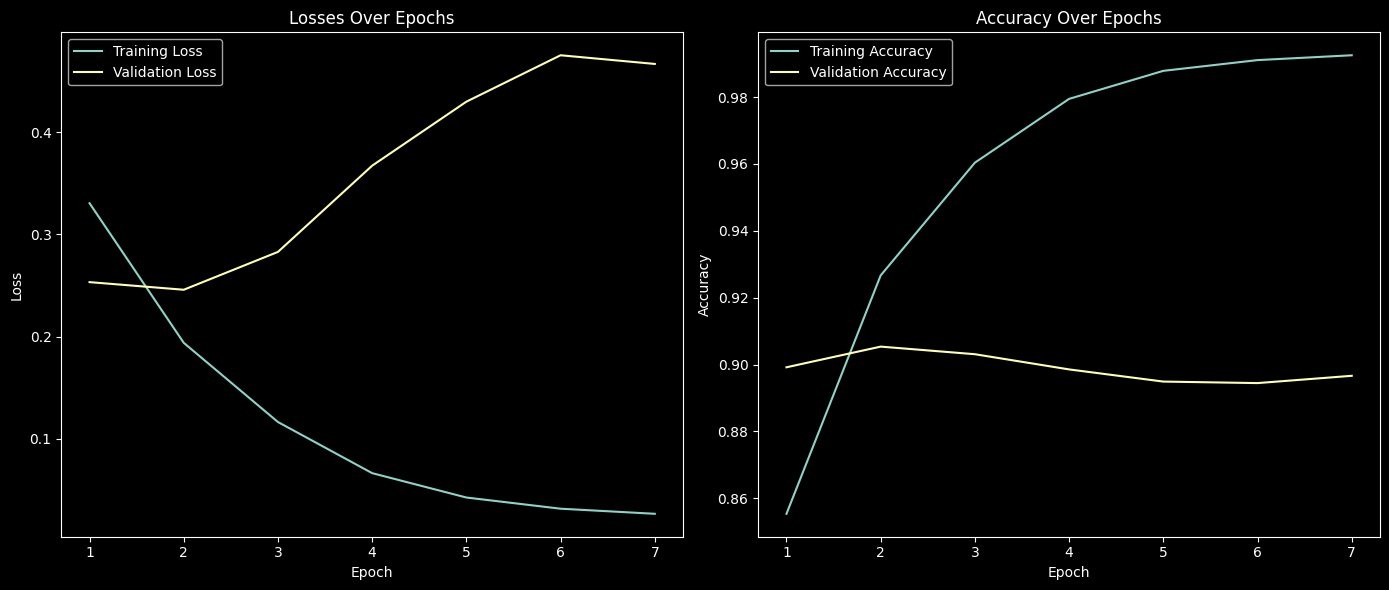

In [26]:
plot_results(results)

In [27]:
model = torch.load('best_model.pth',weights_only=False)
model.to(device)

SentimentLSTM(
  (embedding): Embedding(978029, 128)
  (lstm): LSTM(128, 64, num_layers=3, batch_first=True, bidirectional=True)
  (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [28]:
### Make a Score for each text in the validation set.
test_loss, test_accuracy = score(model, test_loader, criterion,device)
# Print out the results
print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}")

Testing Loss: 0.2444, Testing Accuracy: 0.9063


In [29]:
### Make a prediction for each text in the validation set.
probabilities_test = predict(model, test_loader,device)
predictions_test = torch.argmax(probabilities_test, dim=1)
print(predictions_test[:10])

tensor([1, 0, 0, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')


In [30]:
test_labels = torch.cat([labels for _, labels in tqdm(test_loader,desc="Testing Labels")], dim=0)
test_labels[:10]

Testing Labels: 100%|██████████| 1032/1032 [00:02<00:00, 354.16it/s]


tensor([1, 0, 0, 1, 0, 1, 0, 1, 1, 0])

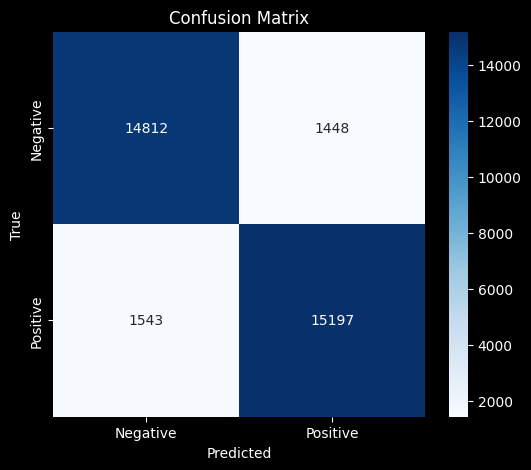

In [31]:
# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels.numpy(), predictions_test.cpu().numpy())
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [32]:
report = classification_report(test_labels.numpy(), predictions_test.cpu().numpy(), target_names=['Negative', 'Positive'])
print("Classification Report :\n",report)

Classification Report :
               precision    recall  f1-score   support

    Negative       0.91      0.91      0.91     16260
    Positive       0.91      0.91      0.91     16740

    accuracy                           0.91     33000
   macro avg       0.91      0.91      0.91     33000
weighted avg       0.91      0.91      0.91     33000



In [33]:
def test_example(model, text, vocab, device):
    model.eval()  
    tokens = preprocess_arabic_text(text) 
    numericalized_text = [vocab[word] if word in vocab else 0 for word in tokens] 
    input_tensor = torch.tensor(numericalized_text, dtype=torch.long).unsqueeze(0).to(device) 
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        prediction = torch.argmax(probs, dim=1).item()
    labels = ['Negative', 'Positive']
    return labels[prediction], probs.cpu().numpy()

In [34]:
example_text = "هذا المنتج رائع جدًا وأحببته كثيرًا"
predicted_label, probabilities = test_example(model, example_text, vocab, device)
print(f"🔹 التوقع: {predicted_label}")
print(f"📊 الاحتمالات: {probabilities}")

🔹 التوقع: Positive
📊 الاحتمالات: [[0.03644883 0.96355116]]


In [35]:
example_text = "الخدمة كانت سيئة جدًا والتعامل غير احترافي"
predicted_label, probabilities = test_example(model, example_text, vocab, device)
print(f"🔹 التوقع: {predicted_label}")
print(f"📊 الاحتمالات: {probabilities}")

🔹 التوقع: Negative
📊 الاحتمالات: [[0.96786267 0.0321373 ]]
